In [2]:
import json
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.utils.data
import cv2
import torch
import torchvision
import os
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps  
import random
print(torchvision.__version__)
print(torch.__version__)
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix


0.14.0
1.13.0


In [3]:
class config:
    CONFIG_SET = 1
    ROOT_DIR  = "./resize_128/test"
    IMAGE_DIR = "./resize_128/test/image"
    MASK_DIR = "./resize_128/test/mask"
    ANNOTATION_DIR =  "./resize_128/test/json"
    MODEL_DIR = "./resize_128/result/model/"
        
    WIDTH = 128
    HEIGHT = 128


    GPU = torch.device("cuda")
    CPU = torch.device("cpu")

    RESNET_MEAN = (0.485, 0.456, 0.406)
    RESNET_STD = (0.229, 0.224, 0.225)

    IMAGE_RESIZE=(128,128)

    BATCH_SIZE = 2

    MOMENTUM = 0.9
    LEARNING_RATE = 0.0001
    WEIGHT_DECAY = 0.0005


    MASK_THRESHOLD = 0.5

    NORMALIZE = False 


    USE_SCHEDULER = False

    NUM_EPOCHS = 4


    BOX_DETECTIONS_PER_IMG = 539

    NUM_CLASSES=2
    
    MIN_SCORE = 0.70

In [4]:
config_set = [
        {
            "ROOT_DIR"  : "./resize_128/test",
            "IMAGE_DIR" : "./resize_128/test/image",
            "MASK_DIR" : "./resize_128/test/mask",
            "ANNOTATION_DIR" :  "./resize_128/test/json",
            "MODEL_DIR" : "./resize_128/result/model/",
            "WIDTH" : 128,
            "HEIGHT" : 128,
            "IMAGE_RESIZE":(128,128),
        },
        {
            "ROOT_DIR"  : "./crop_128/test",
            "IMAGE_DIR" : "./crop_128/test/image",
            "MASK_DIR" : "./crop_128/test/mask",
            "ANNOTATION_DIR" :  "./crop_128/test/json",
            "MODEL_DIR" : "./crop_128/result/model/",
            "WIDTH" : 128,
            "HEIGHT" : 128,
            "IMAGE_RESIZE":(128,128),
        },
        {
            "ROOT_DIR"  : "./resize_512/test",
            "IMAGE_DIR" : "./resize_512/test/image",
            "MASK_DIR" : "./resize_512/test/mask",
            "ANNOTATION_DIR" :  "./resize_512/test/json",
            "MODEL_DIR" : "./resize_512/result/model/",
            "WIDTH" : 512,
            "HEIGHT" : 512,
            "IMAGE_RESIZE":(512,512),
        },
        {
            "ROOT_DIR"  : "./crop_512/test",
            "IMAGE_DIR" : "./crop_512/test/image",
            "MASK_DIR" : "./crop_512/test/mask",
            "ANNOTATION_DIR" :  "./crop_512/test/json",
            "MODEL_DIR" : "./crop_512/result/model/",
            "WIDTH" : 512,
            "HEIGHT" : 512,
            "IMAGE_RESIZE":(512,512),
        }
    ]
def set_config(config_no):
    config.CONFIG_SET = config_no
    config.ROOT_DIR  = config_set[config.CONFIG_SET]["ROOT_DIR"]
    config.IMAGE_DIR = config_set[config.CONFIG_SET]["IMAGE_DIR"]
    config.MASK_DIR = config_set[config.CONFIG_SET]["MASK_DIR"]
    config.ANNOTATION_DIR =config_set[config.CONFIG_SET]["ANNOTATION_DIR"]
    config.MODEL_DIR = config_set[config.CONFIG_SET]["MODEL_DIR"]
    config.WIDTH = config_set[config.CONFIG_SET]["WIDTH"]
    config.HEIGHT = config_set[config.CONFIG_SET]["HEIGHT"]
    config.IMAGE_RESIZE=config_set[config.CONFIG_SET]["IMAGE_RESIZE"]

In [5]:
set_config(3)

In [6]:
data_test = []
for  image,annot,mask in zip(os.listdir(config.IMAGE_DIR), os.listdir(config.ANNOTATION_DIR), os.listdir(config.MASK_DIR)):
    with open(os.path.join(config.ANNOTATION_DIR,annot), "r") as file:
        dictionary = json.load(file)
        dictionary["file"] = os.path.join(config.IMAGE_DIR, image)
        dictionary["mask"] = os.path.join(config.MASK_DIR, mask)
        data_test.append(dictionary)

data_test = pd.DataFrame(data_test)
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        265 non-null    object
 1   n_object    265 non-null    int64 
 2   annotation  265 non-null    object
 3   box         265 non-null    object
 4   mask        265 non-null    object
dtypes: int64(1), object(4)
memory usage: 10.5+ KB


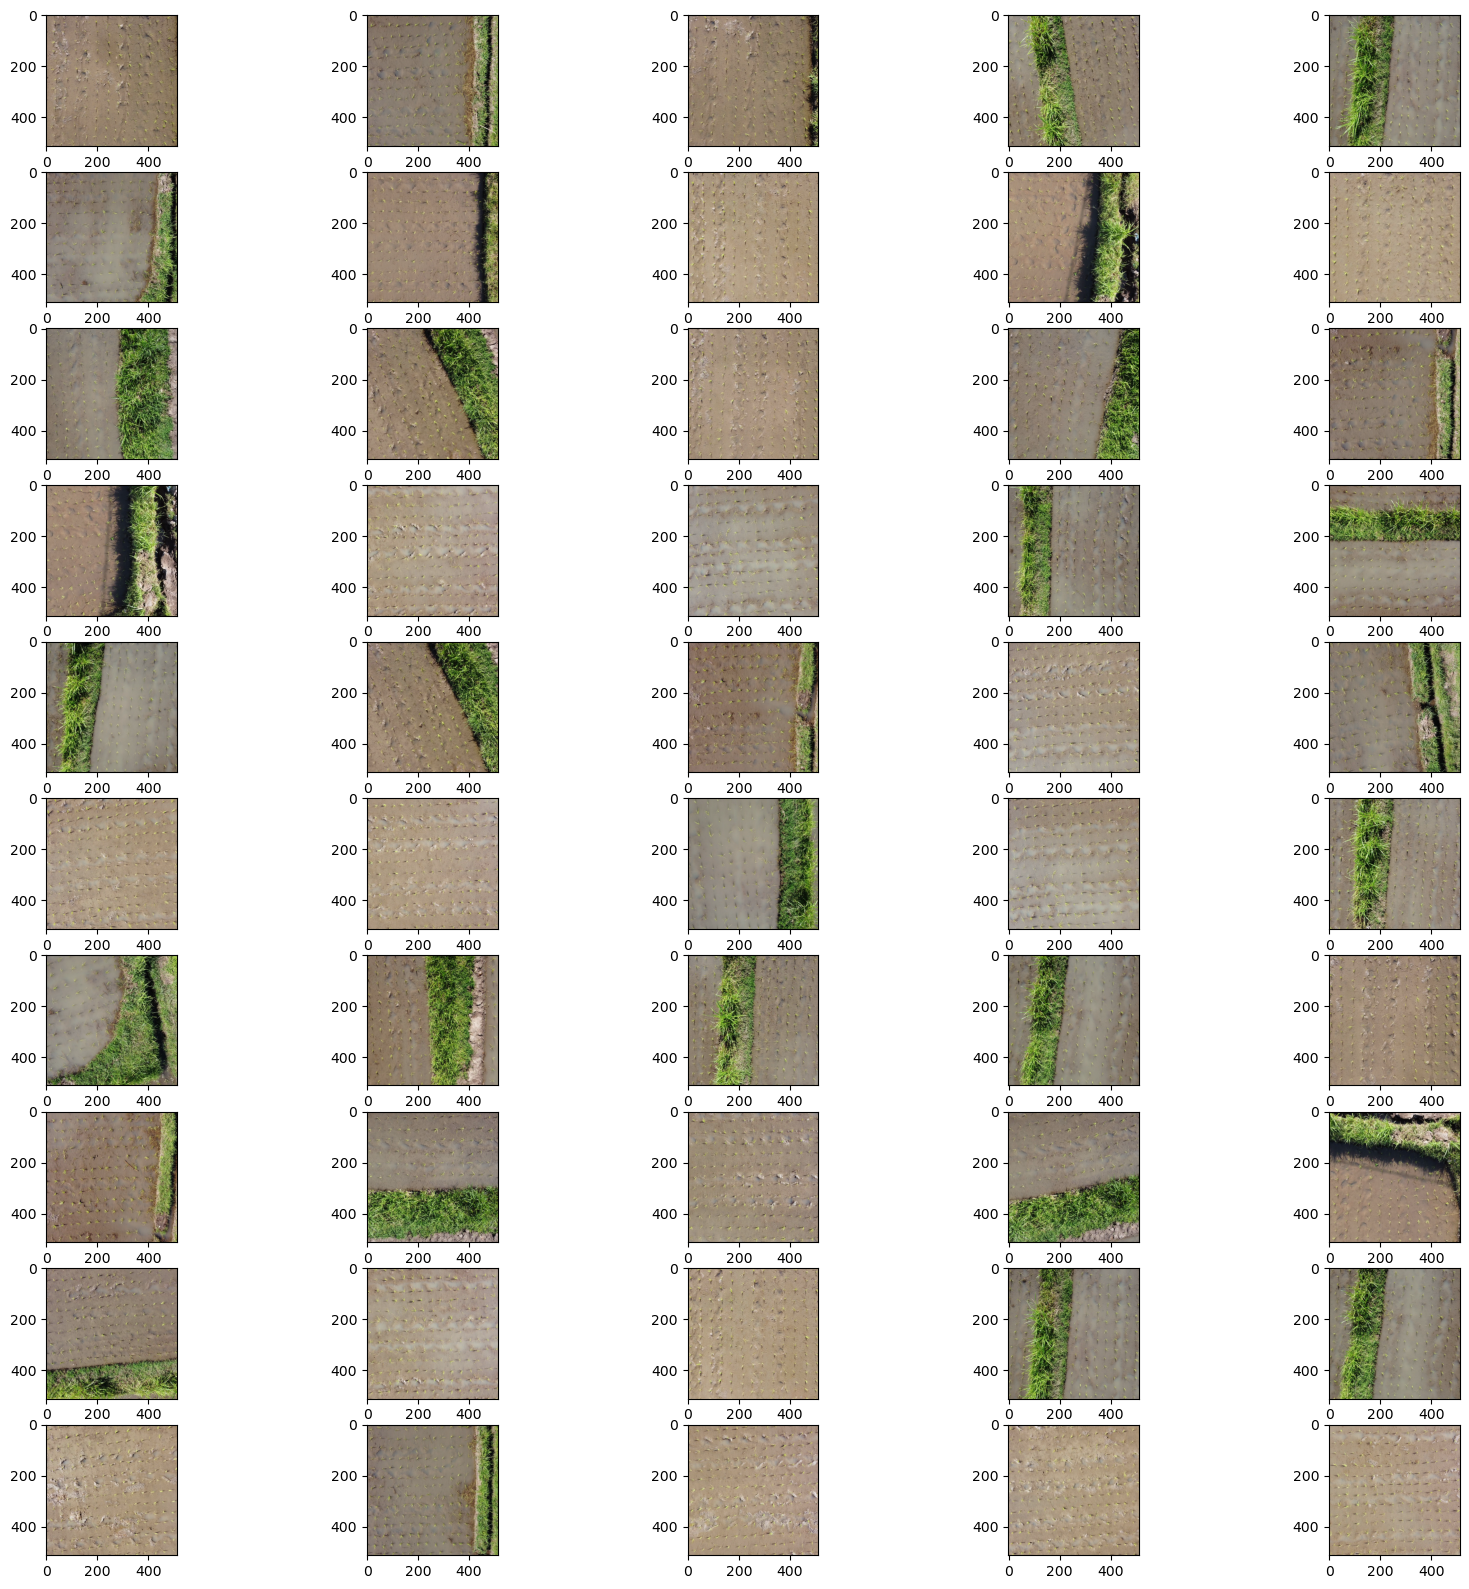

In [7]:
data_length = len(data_test)
w,h = 20,20

fig=plt.figure(figsize=(20, 20))
cols , rows = 5, 10

for i in range(cols*rows):
    if (i) == data_length:
        break
    image = plt.imread(data_test.loc[i,"file"])
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image)

plt.show()

In [8]:
df_log = pd.read_csv(config.MODEL_DIR+'/log.csv')
df_log.head()

epoch  batch  mask_loss      loss  train_loss  train_loss_mask
0      0      1   2.154113  3.377623    0.001828         0.001166
1      0      2   1.684372  2.996479    0.003449         0.002077
2      0      3   2.367603  3.489516    0.005337         0.003358
3      0      4   2.128309  3.239904    0.007091         0.004510
4      0      5   1.151584  2.016013    0.008182         0.005133

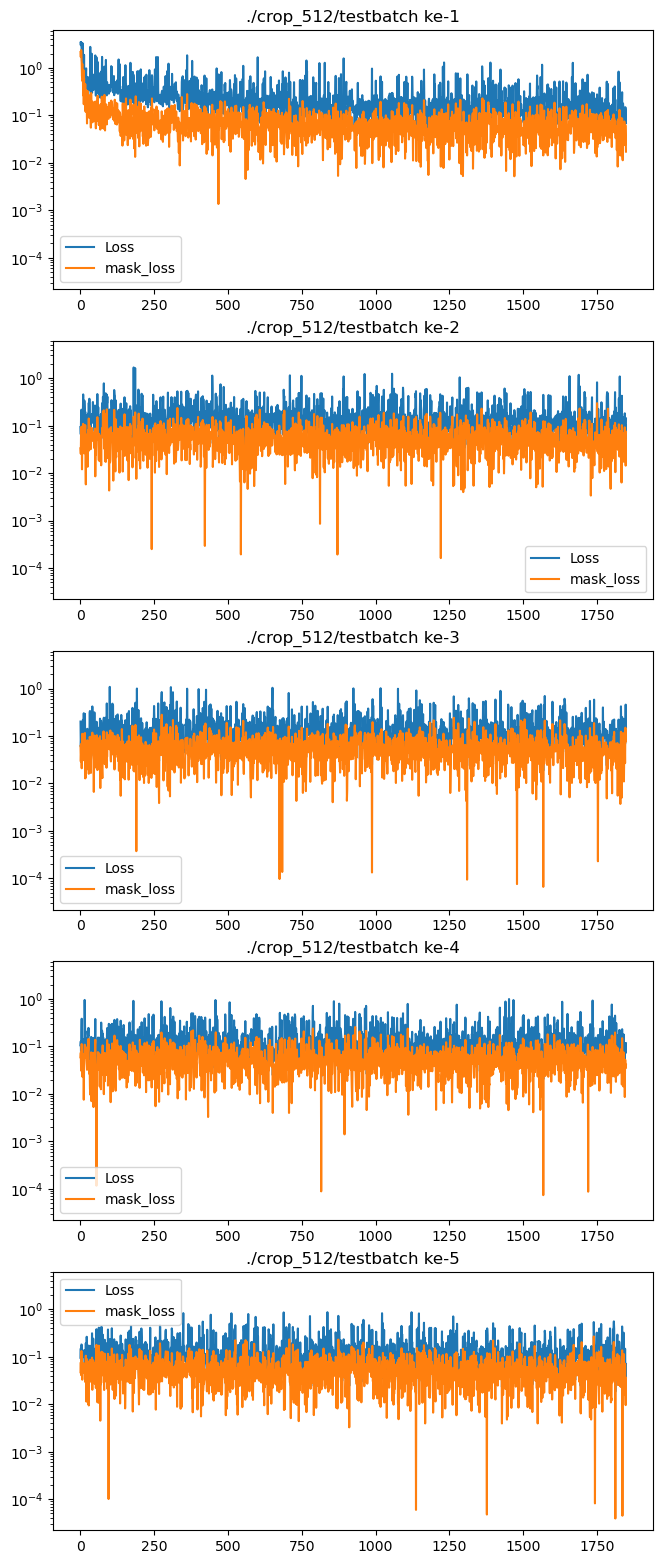

In [9]:
n_epoch = df_log.epoch.unique()
fig, axs = plt.subplots(5,figsize=(6,3*5) ,sharey=True)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0)       
for i in range(5):
    df_epoch = df_log[df_log.epoch == i]
    axs[i].set_title( config.ROOT_DIR+"batch ke-"+ str(i+1) )
    axs[i].set_yscale("log")
    axs[i].plot(df_epoch["batch"], df_epoch["loss"], label="Loss")
    axs[i].plot(df_epoch["batch"], df_epoch["mask_loss"], label="mask_loss")
    axs[i].legend()

# plt.legend()
plt.show()

In [10]:
df_eval = pd.read_csv(config.MODEL_DIR+"/test_result.csv")
df_eval["model"] = df_eval.apply(lambda x: os.path.basename(x["model"]) , axis=1)
df_eval.head()
if len(df_eval) > 5:
    df_eval.drop(df_eval.tail(1).index,inplace=True) # drop last n rows

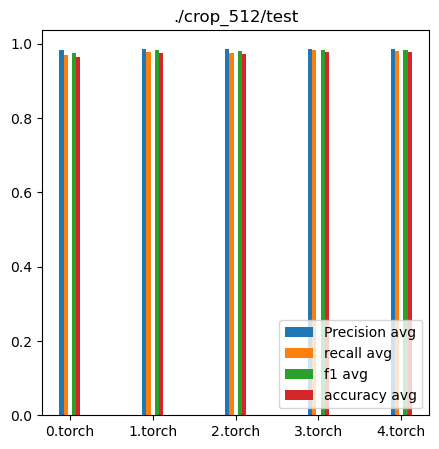

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
x_axis = np.arange(len(df_eval))
width = 0.05
ax.set_title(config.ROOT_DIR)
ax.bar(x_axis - width*2, df_eval['precision_avg'], width, label='Precision avg')
ax.bar(x_axis -width, df_eval['recall_avg'], width, label='recall avg')
ax.bar(x_axis + width, df_eval['f1_avg'], width, label='f1 avg')
ax.bar(x_axis + width*2, df_eval['accuracy_avg'], width, label='accuracy avg')
plt.xticks(x_axis, df_eval["model"])
plt.legend(loc="lower right")
plt.show()

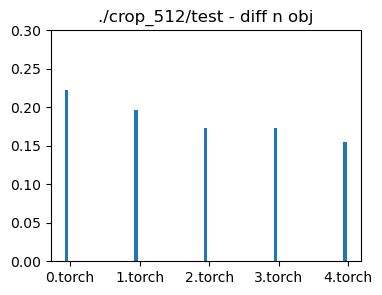

In [12]:
fig, ax = plt.subplots(figsize=(4, 3))
x_axis = np.arange(len(df_eval))
y_axis =np.arange(0.00, 0.31, 0.05)
width = 0.05
ax.set_title(config.ROOT_DIR + " - diff n obj")
ax.bar(x_axis -width, df_eval['diff_n_obj_avg'], width, label='diff_n_obj_avg avg')
plt.xticks(x_axis, df_eval["model"])
plt.yticks(y_axis)
plt.show()

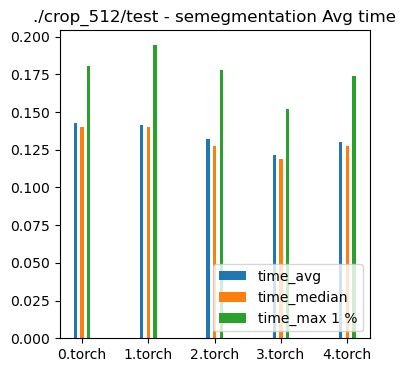

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))
x_axis = np.arange(len(df_eval))
width = 0.05
ax.set_title(config.ROOT_DIR + " - semegmentation Avg time")
ax.bar(x_axis-width*2, df_eval['time_avg'], width, label='time_avg')
ax.bar(x_axis, df_eval['time_median'], width, label='time_median')
ax.bar(x_axis+width*2, df_eval['time_max1/100'], width, label='time_max 1 %')
plt.xticks(x_axis, df_eval["model"])
y_axis =np.arange(0.00, 0.21, 0.025)
plt.yticks(y_axis)
plt.legend(loc="lower right")
plt.show()

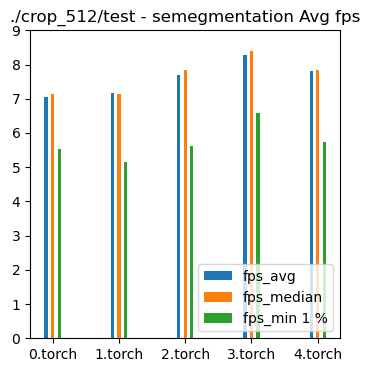

In [14]:
ig, ax = plt.subplots(figsize=(4, 4))
x_axis = np.arange(len(df_eval))
width = 0.05
ax.set_title(config.ROOT_DIR + " - semegmentation Avg fps")
ax.bar(x_axis-width*2, df_eval['fps_avg'], width, label='fps_avg')
ax.bar(x_axis, df_eval['fps_median'], width, label='fps_median')
ax.bar(x_axis+width*2, df_eval['fps_min1/100'], width, label='fps_min 1 %')
plt.xticks(x_axis, df_eval["model"])
y_axis =np.arange(0, 10, 1)
plt.yticks(y_axis)
plt.legend(loc="lower right")
plt.show()

In [15]:
full_data_paths = [config.ROOT_DIR+"/result/"+path+"/data.csv" for path in os.listdir(config.ROOT_DIR+"/result")]
print(full_data_paths)
if len(full_data_paths) == 6:
    full_data_paths.pop()

['./crop_512/test/result/0/data.csv', './crop_512/test/result/1/data.csv', './crop_512/test/result/2/data.csv', './crop_512/test/result/3/data.csv', './crop_512/test/result/4/data.csv']


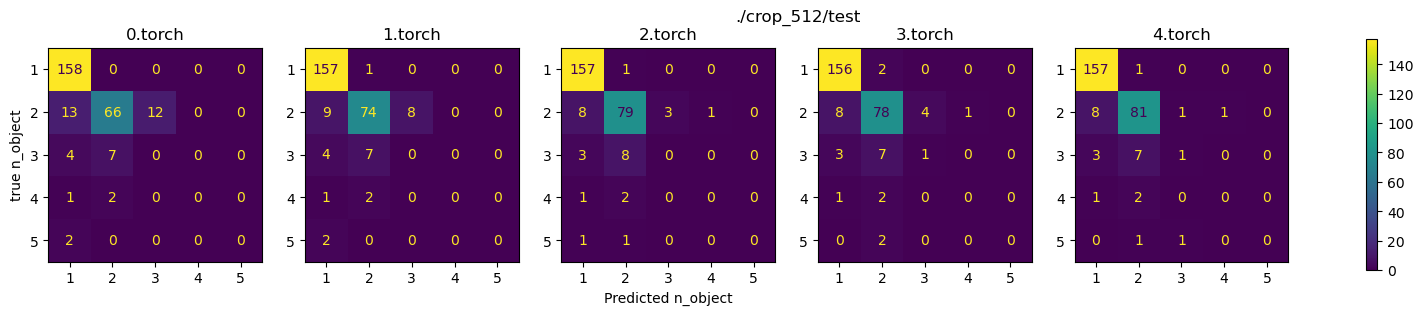

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

f, axes = plt.subplots(1, len(full_data_paths), figsize=(20, 3))
f.suptitle(config.ROOT_DIR)

for i, path in enumerate(full_data_paths):
    df_data_full = pd.read_csv(path)
    cm = confusion_matrix(df_data_full["n_object_label"], df_data_full["n_object"])
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=axes[i])
    axes[i].title.set_text(str(i)+".torch")
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    disp.ax_.set_ylabel('')
    disp.ax_.set_xticklabels(( disp.ax_.get_xticks() +1).astype(str))
    disp.ax_.set_yticklabels(( disp.ax_.get_yticks() +1).astype(str))
    if i==0:
        disp.ax_.set_ylabel('true n_object')
    if i==2:
        disp.ax_.set_xlabel('Predicted n_object')

# f.text(0.4, 0.1, 'Predicted n_object', ha='left')
# plt.subplots_adjust(wspace=0.40, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()




In [17]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,box_detections_per_img=config.BOX_DETECTIONS_PER_IMG)
in_features=model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,config.NUM_CLASSES)
in_features_mask=model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer=256
model.roi_heads.mask_predictor=MaskRCNNPredictor(in_features_mask,hidden_layer,config.NUM_CLASSES)
for param in model.parameters():
    param.requires_grad=True

d:\pytorch_rice_mrcnn\pytorch-rice\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
d:\pytorch_rice_mrcnn\pytorch-rice\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


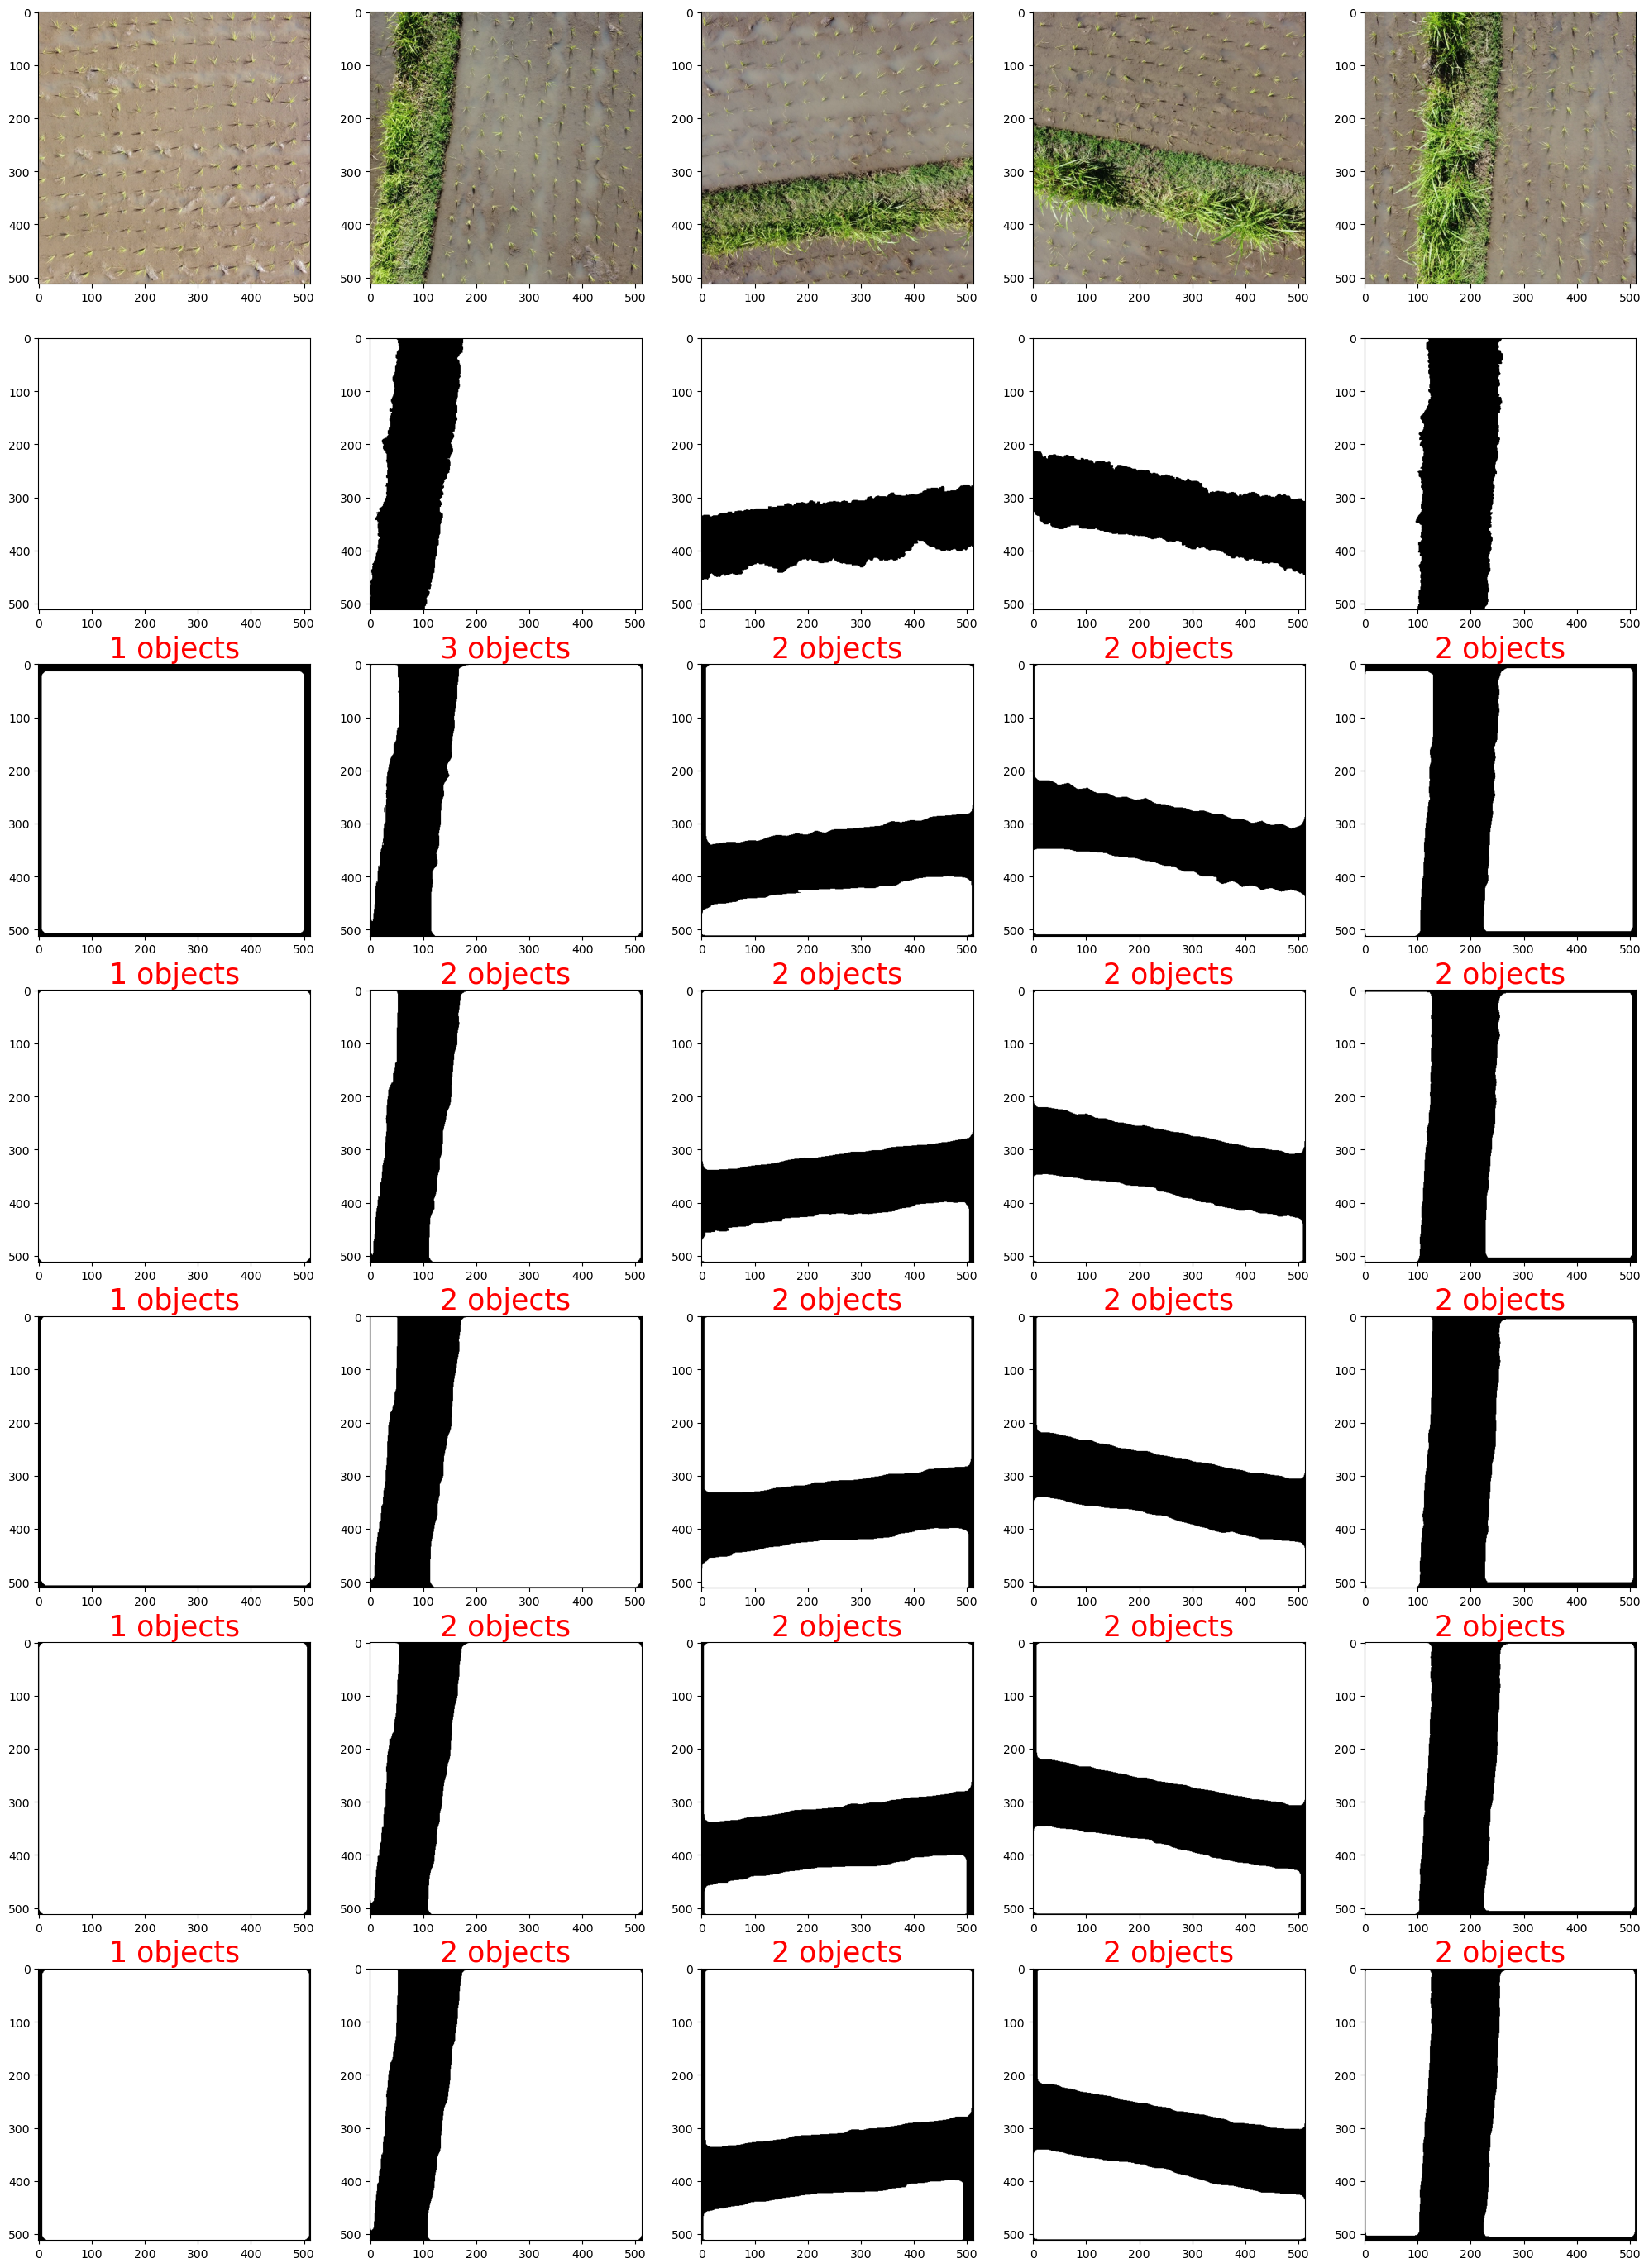

In [18]:
model_paths = [os.path.join(config.MODEL_DIR,path) for path in os.listdir(config.MODEL_DIR) if path.endswith(".torch")]
if len(model_paths) == 6:
    model_paths.pop()
sample = data_test.sample(5)
cols , rows = len(sample), len(model_paths)+2
fig = plt.figure(figsize=(cols*5, rows*5))
cell = 0

for data_path in sample["file"]:
    img = Image.open(data_path)
    cell+=1
    fig.add_subplot(rows, cols, cell)
    plt.imshow(img)

for mask_path in sample["mask"]:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # mask_bin = np.where(mask > 0, 1, 0)
    mask = np.logical_not(mask)
    mask = Image.fromarray(mask)
    cell+= 1
    fig.add_subplot(rows, cols, cell)
    plt.imshow(mask)

for model_path in model_paths:
    model.load_state_dict(torch.load(model_path))
    model.to(config.GPU)
    model.eval()
    
    for image_path in sample["file"] :
        image = Image.open(image_path).convert("RGB")
        image = F.to_tensor(image)
        with torch.no_grad():
            pred = model([image.to(config.GPU)])[0]
        
        
        combine_mask = np.zeros((config.HEIGHT, config.WIDTH))
        n_mask = len(pred["masks"])
        for i, mask in enumerate(pred["masks"].detach().cpu().numpy()):
            score = pred["scores"][i].cpu().item()
            if score < config.MIN_SCORE:
                n_mask -=1
                continue
            combine_mask  =  np.logical_or(combine_mask, mask[0] > config.MASK_THRESHOLD)
            
        mask_im = Image.fromarray(combine_mask)
        cell += 1
        fig.add_subplot(rows, cols, cell)
        plt.imshow(mask_im)
        plt.title( str(n_mask)+" objects" ,fontsize = 25 , color = "red")

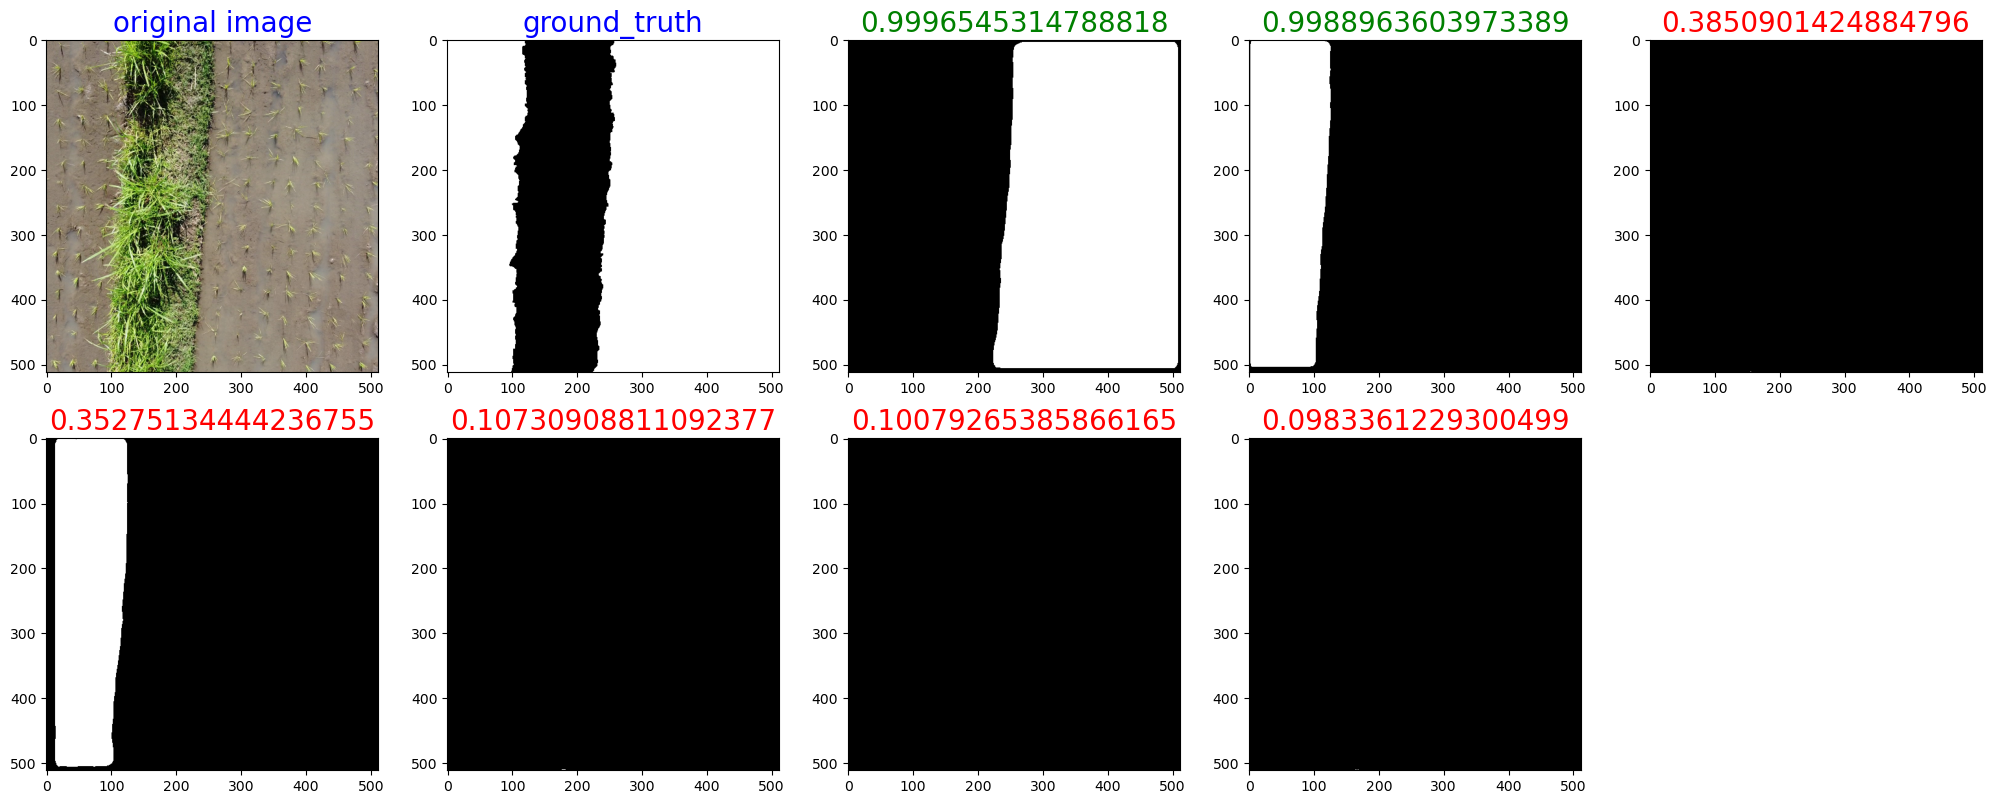

In [19]:
image_id, model_id = 4, 4
image_path = sample.iloc[image_id]["file"]
mask_path = sample.iloc[image_id]["mask"]
model_path = model_paths[model_id]

model.load_state_dict(torch.load(model_path))
model.to(config.GPU)
model.eval()
cols, rows = 5, 5


fig = plt.figure(figsize=(cols*5, rows*5))
cell = 0

img = Image.open(image_path).convert("RGB")
cell += 1
fig.add_subplot(rows, cols, cell)
plt.imshow(img)
plt.title("original image", fontsize=20, color= "blue")

label_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
label_mask = np.logical_not(label_mask)
label_mask = Image.fromarray(label_mask)
cell+= 1
fig.add_subplot(rows, cols, cell)
plt.imshow(label_mask)
plt.title( "ground_truth", fontsize=20, color= "blue")

image = F.to_tensor(img)
with torch.no_grad():
    pred = model([image.to(config.GPU)])[0]

for i, mask in enumerate(pred["masks"].detach().cpu().numpy()):
    score = pred["scores"][i].cpu().item()
    arr_mask = np.zeros((config.HEIGHT, config.WIDTH))
    arr_mask  =  np.logical_or(arr_mask, mask[0] > config.MASK_THRESHOLD)
    pred_mask = Image.fromarray(arr_mask)
    cell += 1
    fig.add_subplot(rows, cols, cell)
    plt.imshow(pred_mask)
    if score < config.MIN_SCORE:
        plt.title( str(score), fontsize = 20, color= "red")
    else:
        plt.title( str(score), fontsize = 20, color= "green")

<class 'numpy.float32'>


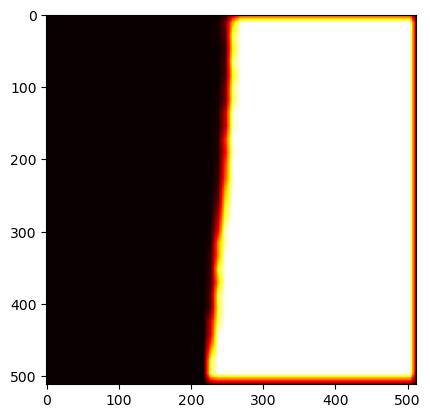

In [20]:
mask_no = 0
mask = pred["masks"].detach().cpu().numpy()[mask_no][0]
print(type(mask[0][0]))
plt.imshow(mask, cmap='hot', interpolation='nearest')
plt 
plt.show()

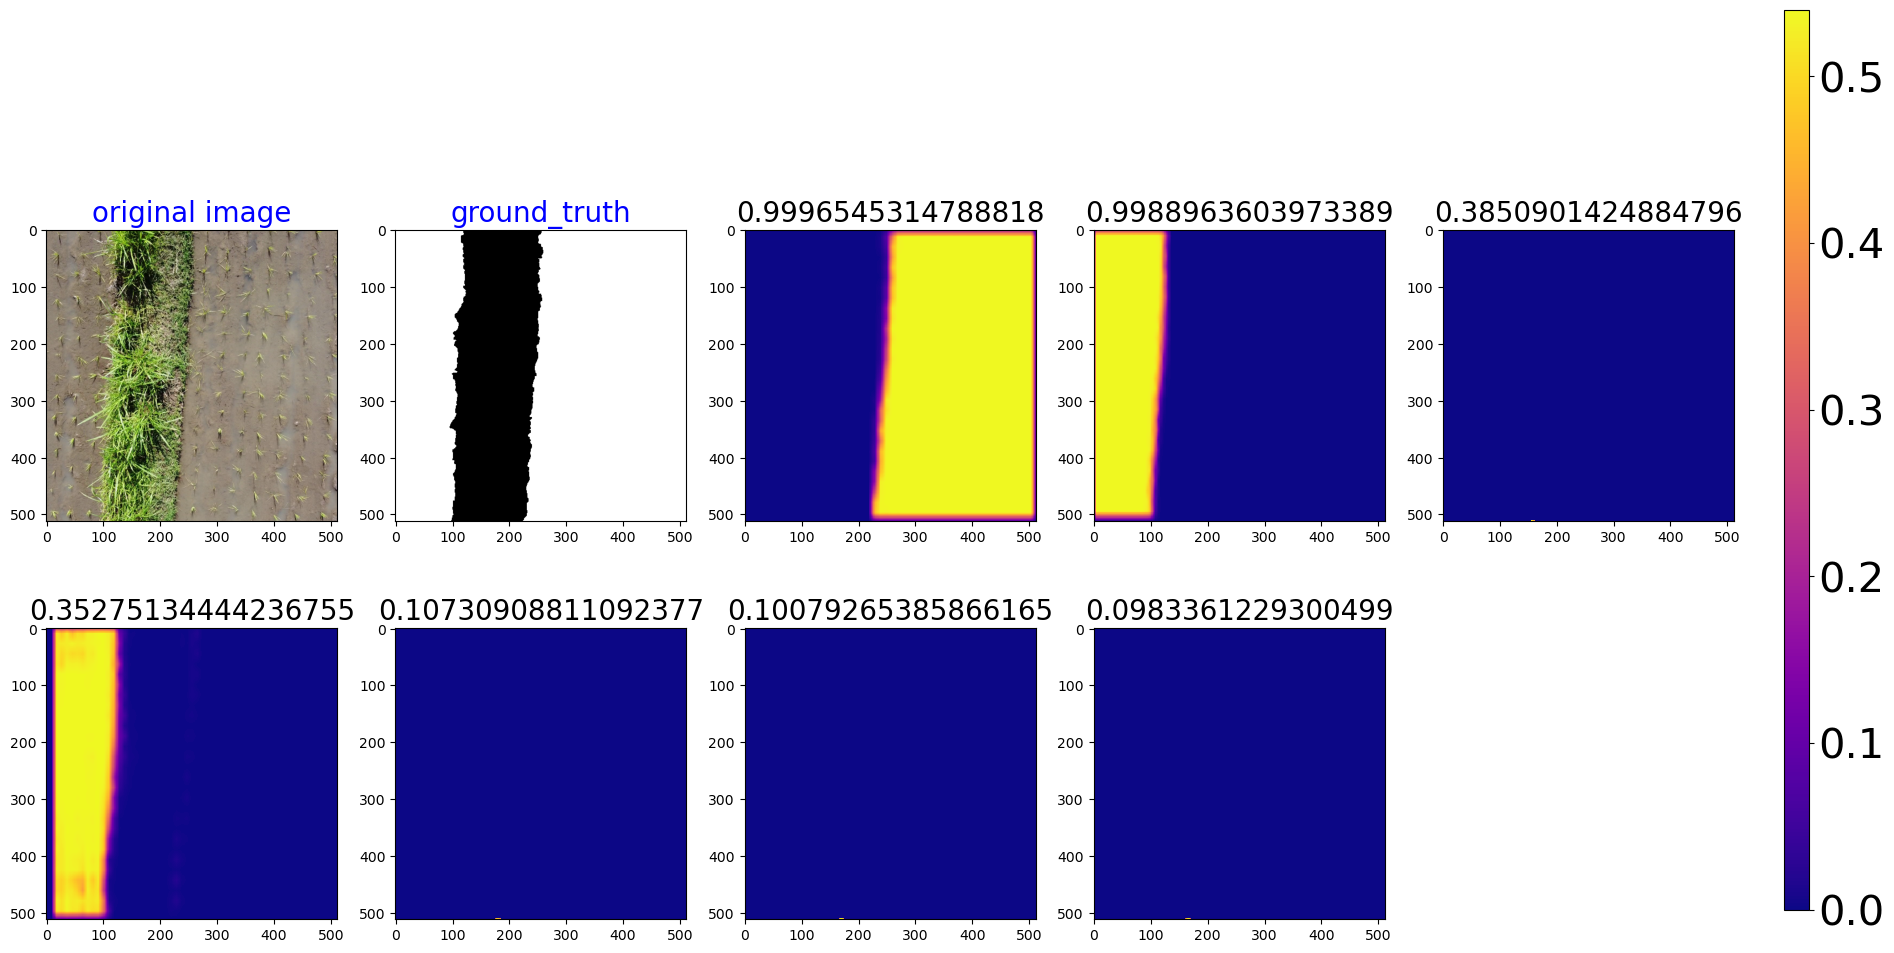

In [21]:
image_id, model_id = 4, 4
image_path = sample.iloc[image_id]["file"]
mask_path = sample.iloc[image_id]["mask"]
model_path = model_paths[model_id]

model.load_state_dict(torch.load(model_path))
model.to(config.GPU)
model.eval()
cols, rows = 5, 5


fig = plt.figure(figsize=(cols*5, rows*5))
cell = 0

img = Image.open(image_path).convert("RGB")
cell += 1
fig.add_subplot(rows, cols, cell)
plt.imshow(img)
plt.title("original image", fontsize=20, color= "blue")

label_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
label_mask = np.logical_not(label_mask)
label_mask = Image.fromarray(label_mask)
cell+= 1
fig.add_subplot(rows, cols, cell)
plt.imshow(label_mask)
plt.title( "ground_truth", fontsize=20, color= "blue")

image = F.to_tensor(img)
with torch.no_grad():
    pred = model([image.to(config.GPU)])[0]

for i, mask in enumerate(pred["masks"].detach().cpu().numpy()):
    score = pred["scores"][i].cpu().item()
    cell += 1
    fig.add_subplot(rows, cols, cell)
    im = plt.imshow(mask[0], cmap='plasma', interpolation='nearest')
    if score < config.MIN_SCORE:
        plt.title( str(score), fontsize = 20, color= "black")
    else:
        plt.title( str(score), fontsize = 20, color= "black")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.6, 0.01, ((cell/cols)/rows)])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=30)


(dot.exe:33664): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


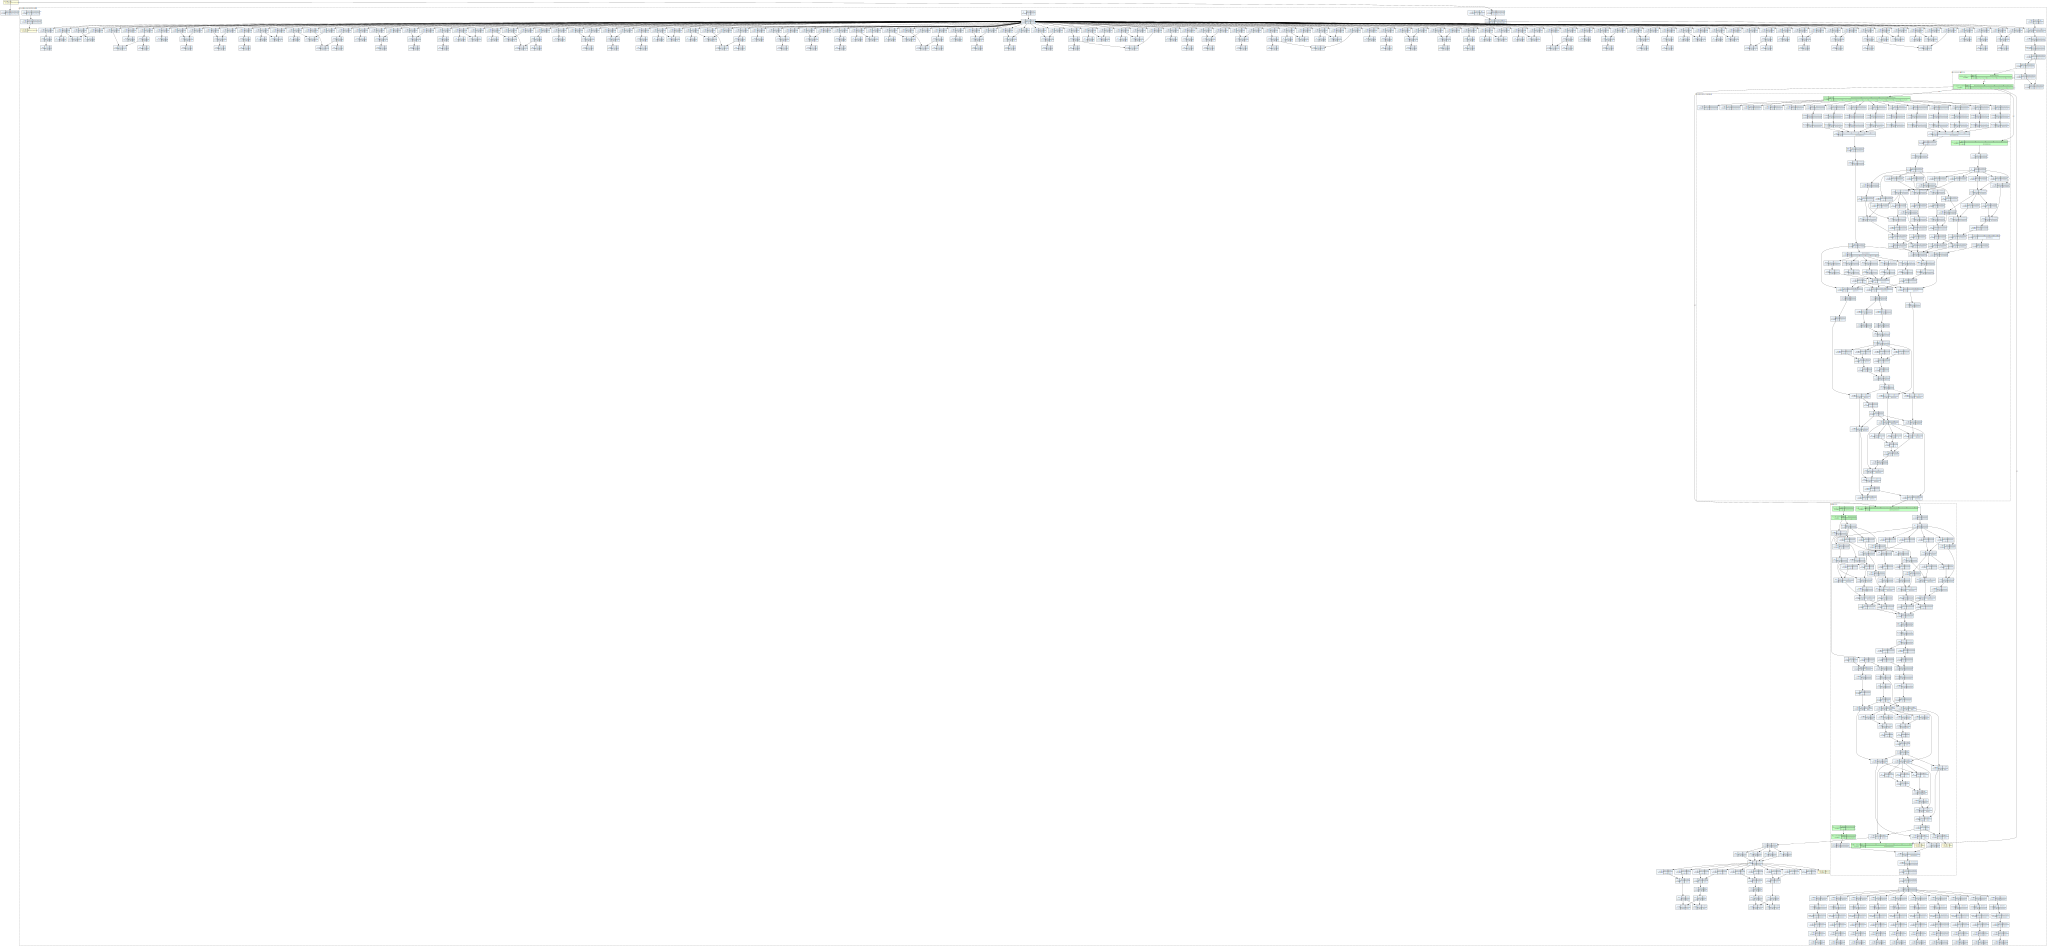

In [53]:
from torchview import draw_graph
# image = F.to_tensor(img)
# with torch.no_grad():
#     pred = model([image.to(config.GPU)])[0]
# print(pred.keys())
# make_dot(pred["boxes"], params=dict(model.named_parameters()))

model_graph = draw_graph(model, input_size =(1, 3, 128, 128), device=config.GPU,depth = 3, expand_nested=True,  hide_inner_tensors=True,
    hide_module_functions=False)
model_graph.visual_graph